Dans cette situation, le défi réside dans la mise en place d'une approche modernisée de Big Data/IA pour la prédiction d'octroi de crédit au sein d'une banque. Le responsable de la ligne de produit crédit à la consommation souhaite prendre des décisions éclairées sur l'attribution des crédits en se basant sur des données antérieures.

La banque dispose d'un ensemble de données comprenant plus de 18 500 crédits, chacun caractérisé par un indicateur et 41 paramètres. L'indicateur, figurant dans la colonne "indicatrice" du fichier de données, distingue les crédits bien remboursés des problématiques (1 indique un problème sur le crédit).

Sur le plan financier, la banque réalise un gain de 4 000 € par crédit bien remboursé, mais subit une perte moyenne de 13 000 € par crédit problématique.

La mission consiste à élaborer une solution Data, accompagnée d'un mode d'emploi, répondant à la demande du responsable de la ligne produit. L'objectif final est d'optimiser l'espérance de bénéfice de la banque dans le processus d'octroi de crédit.

In [133]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
CSV_FILE = 'Data_Finance_TrainEtVal_13Nov23.csv'

In [134]:
df = pd.read_csv(CSV_FILE,sep=';')
df.head()

,Id,GENR,produit,age du bien,mode de paiement,montant demande (centimes),delai paiement,apport,apport %,date demande,...,impayes,charge,fichage3,revenus,secteur activite,code postal,Chiffre d'affaires,Capital social,Indicatrice,Label
0,4212339,VP,LLD,0,10,4967310,10,0,0.0,04/01/2010 09:59,...,0,0,0,0,77,95100,0,200000,0,Train
1,4212408,VP,CB,0,10,1228763,0,245753,20.0,04/01/2010 10:58,...,0,0,0,100000,41,93600,0,750000,0,Train
2,4212504,VU,CB,0,10,1262250,0,189338,15.0,04/01/2010 12:44,...,0,0,0,100000,43,47130,0,500000,0,Train
3,4212509,,LLD,0,10,1500000,10,0,0.0,04/01/2010 13:19,...,0,0,0,400000,66,67500,0,1000000,0,Train
4,4212561,VU,LLD,0,10,2393850,10,0,0.0,04/01/2010 14:43,...,0,0,0,300000,49,60110,0,750000,0,Train


In [135]:
for col in df.columns:
  if(df[col].apply(pd.to_numeric, errors='coerce').notna().all()):
    df[col] = (df[col].apply(pd.to_numeric, errors='coerce'))

df.head()
df['Label'] = df['Label'].apply(lambda x: 1 if x == 'Train' else 0).astype('int64')

In [137]:
categorical_columns = [
    'produit',
    'alerte fraude',
    'Connu',
    'contentieux',
    'fichage1',
    'dirigeant client',
    'fichage2',
    'fichage',
    'incapacite',
    'procédure collective BdF',
    'procédure collective ORT',
    
]

numerical_columns = [col for col in df.columns if df[col].dtype == 'float64' or df[col].dtype == 'int64']
columns_to_keep = categorical_columns + numerical_columns 
df = df[columns_to_keep]
df = df.drop('Id',axis=1)


KeyError: "['Id'] not found in axis"

In [139]:
df.to_csv('data_clean.csv',index=False)
clean_df = df

In [140]:
clean_df['Label'].value_counts()

Label
1    11804
0     6712
Name: count, dtype: int64

In [141]:
one_hot_encoded_df = pd.get_dummies(clean_df, columns=categorical_columns)
one_hot_encoded_df.head()

,age du bien,mode de paiement,montant demande (centimes),delai paiement,apport,apport %,duree,existence impaye regularise,presence homonyme,Montant,...,fichage_,fichage_N,fichage_O,incapacite_,incapacite_N,incapacite_O,procédure collective BdF_N,procédure collective BdF_O,procédure collective ORT_N,procédure collective ORT_O
0,0,10,4967310,10,0,0.0,12,0,0,0,...,False,True,False,True,False,False,True,False,True,False
1,0,10,1228763,0,245753,20.0,60,0,0,0,...,False,True,False,True,False,False,True,False,True,False
2,0,10,1262250,0,189338,15.0,60,0,0,0,...,False,True,False,True,False,False,True,False,True,False
3,0,10,1500000,10,0,0.0,23,0,0,0,...,False,True,False,True,False,False,True,False,True,False
4,0,10,2393850,10,0,0.0,36,0,0,0,...,False,True,False,True,False,False,True,False,True,False


In [142]:
X_train = one_hot_encoded_df[one_hot_encoded_df['Label'] == 1].drop(['Label','Indicatrice'], axis=1)
X_test = one_hot_encoded_df[one_hot_encoded_df['Label'] == 0].drop(['Label','Indicatrice'], axis=1)
y_train = clean_df[clean_df['Label'] == 1]['Indicatrice']
y_test = clean_df[clean_df['Label'] == 0]['Indicatrice']

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6466
           1       0.43      0.01      0.02       246

    accuracy                           0.96      6712
   macro avg       0.70      0.51      0.50      6712
weighted avg       0.94      0.96      0.95      6712



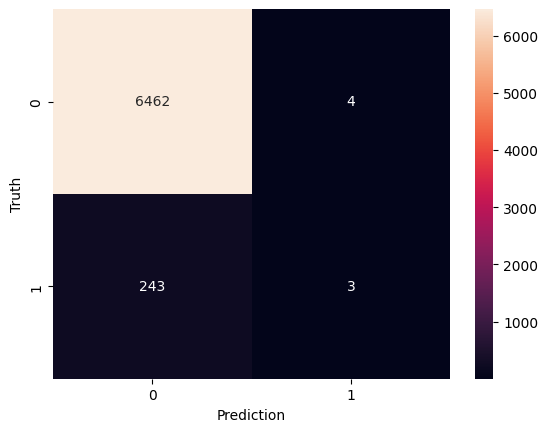

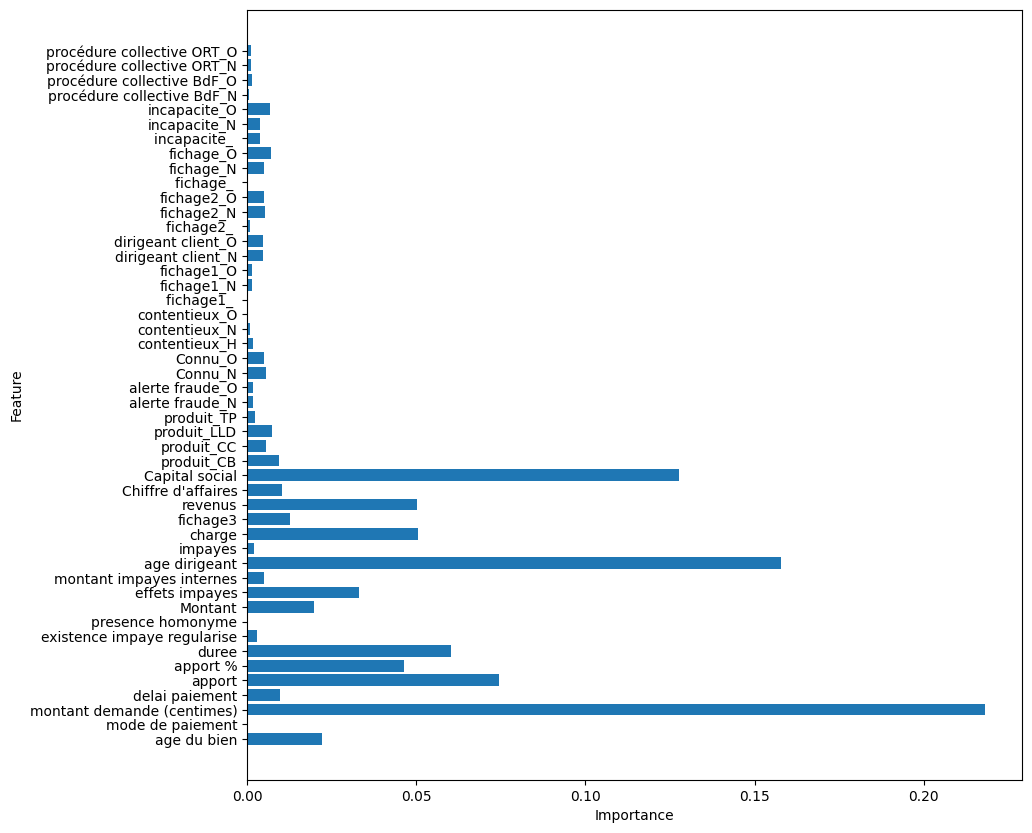

In [146]:
# Apply random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)
random_forest.fit(X_train, y_train)

# Predict
y_pred = random_forest.predict(X_test)

# Evaluate
accuracy_score(y_test, y_pred)

# Evaluate other metrics
confusion_matrix(y_test, y_pred)

# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Truth')

# plot feature importance
plt.figure(figsize=(10,10))
# plot bar order by importance
plt.barh(X_train.columns, random_forest.feature_importances_)

plt.xlabel('Importance')
plt.ylabel('Feature')


print(classification_report(y_test, y_pred))


In [149]:
# Test logistic regression
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6466
           1       0.20      0.00      0.01       246

    accuracy                           0.96      6712
   macro avg       0.58      0.50      0.49      6712
weighted avg       0.94      0.96      0.95      6712



/home/bast7594/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [150]:
# Test MLP
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6466
           1       0.02      0.00      0.01       246

    accuracy                           0.96      6712
   macro avg       0.49      0.50      0.49      6712
weighted avg       0.93      0.96      0.94      6712



In [151]:
# Test SVM
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6466
           1       0.00      0.00      0.00       246

    accuracy                           0.96      6712
   macro avg       0.48      0.50      0.49      6712
weighted avg       0.93      0.96      0.95      6712



/home/bast7594/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bast7594/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bast7594/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
